# IMPORT LIBRARY

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, Add, Multiply, DepthwiseConv2D, Dense, Input, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

Fontconfig warning: ignoring UTF-8: not a valid region tag


# DATASET

In [2]:
print("Class Distribution in Training Set:")
print(train_metadata['benign_malignant'].value_counts())

print("\nClass Distribution in Validation Set:")
print(val_metadata['benign_malignant'].value_counts())

print("\nAge Statistics in Training Set:")
print(train_metadata['age_approx'].describe())

# Display sample images with labels
def show_sample_images(generator, num_samples=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title('Malignant' if labels[i] == '1' else 'Benign')
        plt.axis('off')
    plt.show()

print("\nSample Training Images:")
show_sample_images(train_generator)

Class Distribution in Training Set:


NameError: name 'train_metadata' is not defined

# MODEL


# mobnet my impl

In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the metadata CSV file
metadata_file_path = 'dataset/ISIC2020/train/ISIC_2020_Training_GroundTruth_v2.csv' 
metadata = pd.read_csv(metadata_file_path)

# Define the path to the images
images_folder_path = 'dataset/ISIC2020/train/train_images'

# Add file extension to image names (if not already present)
metadata['image_name'] = metadata['image_name'].apply(lambda x: f"{x}.jpg")

# Map benign and malignant labels to '0' and '1' as strings
metadata['label'] = metadata['benign_malignant'].map({'benign': '0', 'malignant': '1'})

# Split metadata into training and validation sets
train_metadata, val_metadata = train_test_split(metadata, test_size=0.2, random_state=42)

# Define ImageDataGenerator for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale images to [0, 1]
    # Add other augmentation parameters as needed
)

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,
    directory=images_folder_path,
    x_col='image_name',
    y_col='label',  # Use 'label' instead of 'benign_malignant'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=True  # Shuffle data if needed
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_metadata,
    directory=images_folder_path,
    x_col='image_name',
    y_col='label',  # Use 'label' instead of 'benign_malignant'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=False  # No need to shuffle validation data
)

# Print the first few rows of metadata to verify loading (optional)
print(metadata.head())

# Print the first few filenames from train_generator (optional)
print(train_generator.filenames[:10])

# Verify the number of images found
print(f"Found {train_generator.samples} training images and {val_generator.samples} validation images.")

# Perform any additional data preprocessing as needed (scaling, encoding categorical variables)

# # Example preprocessing for age (assuming 'age_approx' is a numerical column)
# age_scaler = StandardScaler()
# metadata['age_approx'] = age_scaler.fit_transform(metadata[['age_approx']])

# # Example preprocessing for gender (assuming 'sex' is categorical)
# gender_encoder = OneHotEncoder()
# gender_encoded = gender_encoder.fit_transform(metadata[['sex']])
# metadata = pd.concat([metadata, pd.DataFrame(gender_encoded.toarray(), columns=gender_encoder.get_feature_names_out(['sex']))], axis=1)

# # Example preprocessing for anatomical site (assuming 'anatomical_site_general_challenge' is categorical)
# position_encoder = OneHotEncoder()
# position_encoded = position_encoder.fit_transform(metadata[['anatom_site_general_challenge']])
# metadata = pd.concat([metadata, pd.DataFrame(position_encoded.toarray(), columns=position_encoder.get_feature_names_out(['anatom_site_general_challenge']))], axis=1)

# # Drop original categorical columns after encoding if needed
# metadata.drop(['sex', 'anatom_site_general_challenge'], axis=1, inplace=True)

# # Merge image filenames and metadata based on 'image_name' for further analysis
# merged_data = pd.merge(pd.DataFrame(train_generator.filenames, columns=['image_name']), metadata, on='image_name')

# # Verify the merged data
# print(merged_data.head())

Found 26499 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.
         image_name  patient_id   lesion_id     sex  age_approx  \
0  ISIC_2637011.jpg  IP_7279968  IL_7972535    male        45.0   
1  ISIC_0015719.jpg  IP_3075186  IL_4649854  female        45.0   
2  ISIC_0052212.jpg  IP_2842074  IL_9087444  female        50.0   
3  ISIC_0068279.jpg  IP_6890425  IL_4255399  female        45.0   
4  ISIC_0074268.jpg  IP_8723313  IL_6898037  female        55.0   

  anatom_site_general_challenge diagnosis benign_malignant  target label  
0                     head/neck   unknown           benign       0     0  
1               upper extremity   unknown           benign       0     0  
2               lower extremity     nevus           benign       0     0  
3                     head/neck   unknown           benign       0     0  
4               upper extremity   unknown           benign       0     0  
['ISIC_6933350.jpg', 'IS

/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the metadata CSV file
metadata_file_path = 'dataset/ISIC2020/train/ISIC_2020_Training_GroundTruth_v2.csv'
metadata = pd.read_csv(metadata_file_path)

# Count occurrences of each class
count_benign = metadata[metadata['benign_malignant'] == 'benign'].shape[0]
count_malignant = metadata[metadata['benign_malignant'] == 'malignant'].shape[0]

# Calculate the number of benign samples to keep, for example, keeping 70% of the benign samples
keep_benign_ratio = 0.4
num_keep_benign = int(count_benign * keep_benign_ratio)

# Randomly sample benign samples to match the number of malignant samples
metadata_balanced = pd.concat([
    metadata[metadata['benign_malignant'] == 'benign'].sample(num_keep_benign, replace=False, random_state=42),
    metadata[metadata['benign_malignant'] == 'malignant']
])

# Define the path to the images
images_folder_path = 'dataset/ISIC2020/train/train_images'

# Add file extension to image names (if not already present)
metadata_balanced['image_name'] = metadata_balanced['image_name'].apply(lambda x: f"{x}.jpg")

# Map benign and malignant labels to '0' and '1' as strings
metadata_balanced['label'] = metadata_balanced['benign_malignant'].map({'benign': '0', 'malignant': '1'})

# Split metadata into training and validation sets
train_metadata, val_metadata = train_test_split(metadata_balanced, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = {
    '0': 1.0,  # Class '0' (benign) weight
    '1': count_benign / count_malignant  # Class '1' (malignant) weight
}

# Define ImageDataGenerator for training and validation sets with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale images to [0, 1]
    rotation_range=20,    # Rotate images by 20 degrees
    width_shift_range=0.1,  # Shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # Shift images vertically (fraction of total height)
    shear_range=0.1,      # Shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.1,       # Randomly zoom images
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,    # Flip images vertically
    fill_mode='nearest'   # Fill in missing pixels with the nearest value
)

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Create generators with class weights and augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,
    directory=images_folder_path,
    x_col='image_name',
    y_col='label',  # Use 'label' instead of 'benign_malignant'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=True,  # Shuffle data if needed
    class_weight=class_weights  # Assign class weights
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_metadata,
    directory=images_folder_path,
    x_col='image_name',
    y_col='label',  # Use 'label' instead of 'benign_malignant'
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=False  # No need to shuffle validation data
)

# Print the counts of benign and malignant samples after weighting
print(f"Training set - Benign: {train_metadata[train_metadata['label'] == '0'].shape[0]}, Malignant: {train_metadata[train_metadata['label'] == '1'].shape[0]}")
print(f"Validation set - Benign: {val_metadata[val_metadata['label'] == '0'].shape[0]}, Malignant: {val_metadata[val_metadata['label'] == '1'].shape[0]}")

# Print the first few rows of metadata to verify loading (optional)
print(metadata_balanced.head())

# Print the first few filenames from train_generator (optional)
print(train_generator.filenames[:10])

# Verify the number of images found
print(f"Found {train_generator.samples} training images and {val_generator.samples} validation images.")

Found 10880 validated image filenames belonging to 2 classes.
Found 2720 validated image filenames belonging to 2 classes.
Training set - Benign: 10419, Malignant: 461
Validation set - Benign: 2597, Malignant: 123
             image_name  patient_id   lesion_id     sex  age_approx  \
30065  ISIC_9085719.jpg  IP_3562983  IL_5530050    male        35.0   
12966  ISIC_3990124.jpg  IP_9909432  IL_9698216    male        35.0   
16757  ISIC_5125438.jpg  IP_1139701  IL_3768935  female        45.0   
9914   ISIC_3076237.jpg  IP_9802994  IL_9979757  female        40.0   
17057  ISIC_5209007.jpg  IP_1051664  IL_8930710    male        35.0   

      anatom_site_general_challenge diagnosis benign_malignant  target label  
30065                         torso   unknown           benign       0     0  
12966                         torso   unknown           benign       0     0  
16757                         torso   unknown           benign       0     0  
9914                          torso   unkno

In [10]:
class hswish(tf.keras.layers.Layer):
    def __init__(self):
        super(hswish, self).__init__()

    def call(self, inputs):
        return inputs * tf.nn.relu6(inputs + 3) / 6.0
        

class SqueezeAndExcite(Layer):
    def __init__(self, in_size, reduction=4):
        super(SqueezeAndExcite, self).__init__()
        self.avg_pool = GlobalAveragePooling2D()
        self.reshape1 = Reshape((1, 1, in_size))
        self.conv1 = Conv2D(in_size // reduction, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(in_size, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.bn2 = BatchNormalization()
        self.sigmoid = tf.keras.activations.sigmoid
    
    def call(self, x):
        scale = self.avg_pool(x)  # Global average pooling
        scale = self.reshape1(scale)  # Reshape to (batch_size, 1, 1, in_size)
        scale = self.conv1(scale)
        scale = self.bn1(scale)
        scale = self.relu(scale)
        scale = self.conv2(scale)
        scale = self.bn2(scale)
        scale = self.sigmoid(scale)
        return Multiply()([x, scale])  # Element-wise multiplication

class Block(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation=tf.keras.activations.relu, expansion_factor=1, se_ratio=0):
        super(Block, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expansion_factor = expansion_factor
        self.se_ratio = se_ratio
        self.activation = activation
        
        # Calculate expanded channels
        self.expanded_channels = in_channels * expansion_factor
        
        # Layers initialization 
        if self.expansion_factor != 1:
            self.expansion_conv = tf.keras.layers.Conv2D(self.expanded_channels, kernel_size=1, strides=1, padding='valid', use_bias=False)
            self.expansion_bn = tf.keras.layers.BatchNormalization()
        
        self.depthwise_conv = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, strides=stride, padding='same', depth_multiplier=1, use_bias=False)
        self.depthwise_bn = tf.keras.layers.BatchNormalization()
        
        if se_ratio:
            self.squeeze_excitation = SqueezeAndExcite(self.expanded_channels, reduction=int(in_channels * se_ratio))
        
        self.projection_conv = tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.projection_bn = tf.keras.layers.BatchNormalization()
        
        self.shortcut = tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='valid', use_bias=False) if stride > 1 or in_channels != out_channels else None
    
    def call(self, x):
        identity = x
        
        if self.expansion_factor != 1:
            x = self.expansion_conv(x)
            x = self.expansion_bn(x)
            x = self.activation(x)
        
        x = self.depthwise_conv(x)
        x = self.depthwise_bn(x)
        x = self.activation(x)
        
        if self.se_ratio:
            x = self.squeeze_excitation(x)
        
        x = self.projection_conv(x)
        x = self.projection_bn(x)

        if self.shortcut is not None:
            identity = self.shortcut(identity)
        
        x = Add()([x, identity])  
        x = self.activation(x)
        
        return x

In [34]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, GlobalAveragePooling2D, Flatten
# from tensorflow.keras.layers import concatenate

# def model(input_shape=(224, 224, 3), num_classes=1):
#     # Define inputs
#     inputs_image = Input(shape=input_shape, name='image_input')
#     # inputs_age = Input(shape=(1,), name='age_input')
#     # inputs_sex = Input(shape=(3,), name='sex_input')  # Assuming 3 categories (one-hot encoded)
#     # inputs_position = Input(shape=(6,), name='position_input')  # Assuming 6 anatomical site categories (one-hot encoded)
    
#     # # Flatten image input
#     # flattened_image = Flatten()(inputs_image)
    
#     # # Encoder layers for age, sex, and position
#     # age_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=16)(inputs_age)  # Adjust input_dim based on max age
#     # age_flattened = tf.keras.layers.Flatten()(age_embedding)
#     # sex_dense = tf.keras.layers.Dense(16, activation='relu')(inputs_sex)
#     # position_dense = tf.keras.layers.Dense(32, activation='relu')(inputs_position)
    
#     # Concatenate encoded features with flattened image input
#     #x = concatenate([flattened_image, age_flattened, sex_dense, position_dense])
#     #x = flattened_image
#     # Reshape back to image shape
#     #x = tf.keras.layers.Reshape(target_shape=(224, 224, 3))(x)
    
#     # Initial conv layer
#     x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
    
#     x = Block(16, 24, kernel_size=3, stride=2)(x)
#     x = Block(24, 24, kernel_size=3, stride=2)(x)
#     x = Block(24, 40, kernel_size=3, stride=1)(x)
#     x = Block(40, 40, kernel_size=5, stride=2)(x)
#     x = Block(40, 40, kernel_size=5, stride=1)(x)
#     x = Block(40, 80, kernel_size=5, stride=1)(x)
#     x = Block(80, 80, kernel_size=5, stride=1)(x)
#     x = Block(80, 80, kernel_size=5, stride=1)(x)
#     x = Block(80, 112, kernel_size=5, stride=2, se_ratio=0.5)(x)
#     x = Block(112, 112, kernel_size=5, stride=1, se_ratio=0.5)(x)
#     x = Block(112, 160, kernel_size=5, stride=1, activation=hswish, se_ratio=0.5)(x)

    
#     # Global pooling and final dense layers
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1280, activation='relu')(x)
    
#     # Output layer for binary classification
#     outputs = Dense(num_classes, activation='sigmoid')(x)
    
#     # Define model
#     #model = tf.keras.Model(inputs=[inputs_image, inputs_age, inputs_sex, inputs_position], outputs=outputs)
#     model = tf.keras.Model(inputs=[inputs_image], outputs=outputs)
    
#     return model

# # Create an instance of the model
# model = model()

# # Print model summary
# model.summary()


UnboundLocalError: cannot access local variable 'x' where it is not associated with a value

In [14]:
def model(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = hswish()(x)
    
    x = Block(16, 16, kernel_size=3, stride=2)(x)
    x = Block(16, 24, kernel_size=3, expansion_factor= 4, stride=2)(x)
    x = Block(24, 24, kernel_size=3, expansion_factor= 4,stride=1)(x)
    x = Block(24, 40, kernel_size=5, stride=2, expansion_factor= 4, activation=hswish(), se_ratio=1)(x)
    x = Block(40, 40, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(40, 40, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(40, 48, kernel_size=5, stride=1, expansion_factor= 3, activation=hswish(), se_ratio=1)(x)
    x = Block(48, 48, kernel_size=5, stride=1, expansion_factor= 3, activation=hswish(), se_ratio=1)(x)
    x = Block(48, 96, kernel_size=5, stride=2, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(96, 96, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    x = Block(96, 96, kernel_size=5, stride=1, expansion_factor= 6, activation=hswish(), se_ratio=1)(x)
    
    
    # x = Conv2D(96, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    # x = BatchNormalization()(x)
    # x = hswish()(x)
    # x = Dense(576, activation=None)(x)
    # x = Dropout(0.5)
    # x = BatchNormalization()(x)
    # x = hswish()(x)
    # x = Dense(1280, activation=None)(x)
    # outputs = Dense(num_classes, activation='sigmoid')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(576, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1280, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)  # Example input shape, adjust as per your dataset
model = model(input_shape, num_classes=1)

# Print model summary
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 112, 112, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_201         │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hswish_38 (hswish)              │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_44 (Block)                │ (None, 56, 56, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_45 (Block)                │ (None, 28, 28, 24)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_46 (Block)                │ (None, 28, 28, 24)     │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_47 (Block)                │ (None, 14, 14, 40)     │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_48 (Block)                │ (None, 14, 14, 40)     │        31,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_49 (Block)                │ (None, 14, 14, 40)     │        31,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_50 (Block)                │ (None, 14, 14, 48)     │        17,844 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_51 (Block)                │ (None, 14, 14, 48)     │        20,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_52 (Block)                │ (None, 7, 7, 96)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_53 (Block)                │ (None, 7, 7, 96)       │       139,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_54 (Block)                │ (None, 7, 7, 96)       │       139,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_44     │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 576)            │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1280)           │       738,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,258,457 (4.80 MB)

 Trainable params: 1,242,857 (4.74 MB)

 Non-trainable params: 15,600 (60.94 KB)

In [15]:
early_stopping = EarlyStopping(monitor='loss', 
                               patience=3, 
                               restore_best_weights=True)

history = model.fit(
                train_generator,
                epochs=100,
                validation_data=val_generator,
                callbacks=[early_stopping])

Epoch 1/100


/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 182s 874ms/step
Accuracy: 0.9820
Recall: 0.9820
F1 Score: 0.9731


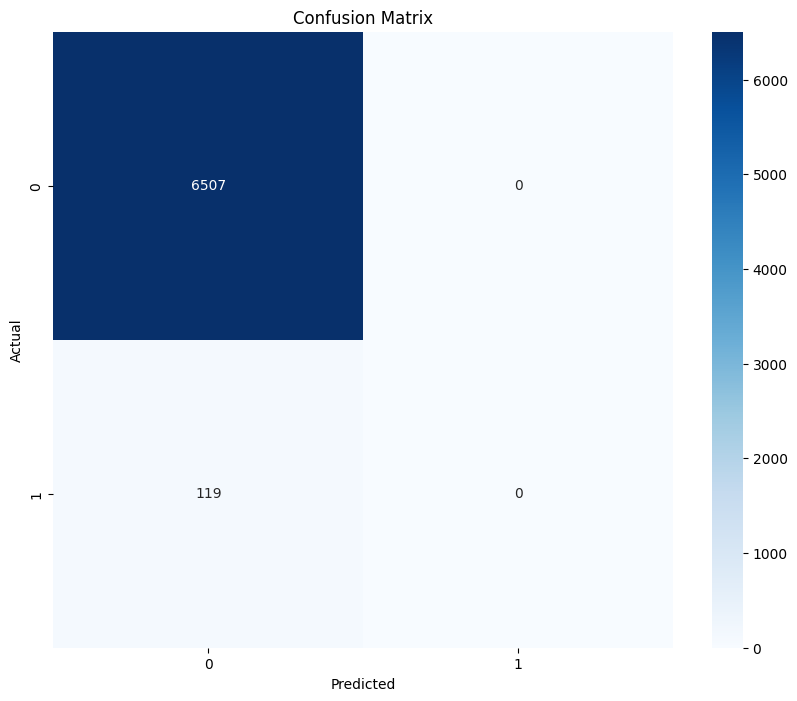

NotImplementedError: 
Object Block was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [79]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Load the test data
test_csv_path = 'dataset/ISIC2020/test/test_images'
test_images_folder = 'dataset/ISIC2020/test/ISIC_2020_Test_Metadata.csv'

# Load the CSV metadata
test_df = pd.read_csv(test_csv_path)

# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images_folder,
    x_col='image_path',  # column in your CSV that contains the image paths
    y_col='label',  # column in your CSV that contains the labels
    target_size=(224, 224),  # size to resize images to
    batch_size=32,
    class_mode='binary',  # 'binary' since it's a binary classification problem
    shuffle=False  # Do not shuffle for evaluation
)

# Predict using the model
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # assuming a threshold of 0.5 for binary classification

# True labels
true_classes = test_generator.classes

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=['Benign', 'Malignant'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Save the model
model.save('skc_bin_class.h5')

# Optionally save the model using joblib if required
joblib.dump(model, 'best_model.joblib')

208/208 ━━━━━━━━━━━━━━━━━━━━ 175s 843ms/step - accuracy: 0.9762 - loss: 0.1645
Validation Loss: 0.14916826784610748
Validation Accuracy: 0.9790220260620117


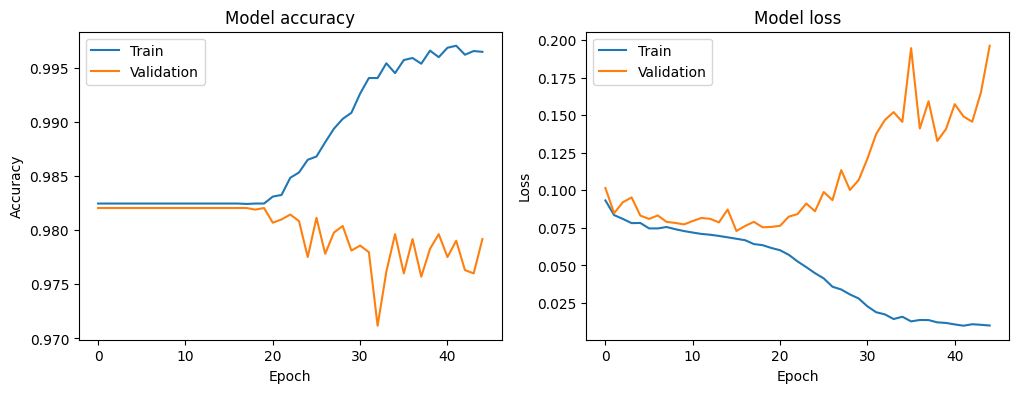

208/208 ━━━━━━━━━━━━━━━━━━━━ 177s 851ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6507
           1       0.00      0.00      0.00       119

    accuracy                           0.98      6626
   macro avg       0.49      0.50      0.50      6626
weighted avg       0.96      0.98      0.97      6626



/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cvproj/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


208/208 ━━━━━━━━━━━━━━━━━━━━ 177s 851ms/step
Confusion Matrix:
 [[6507    0]
 [ 119    0]]
Confusion matrix, without normalization


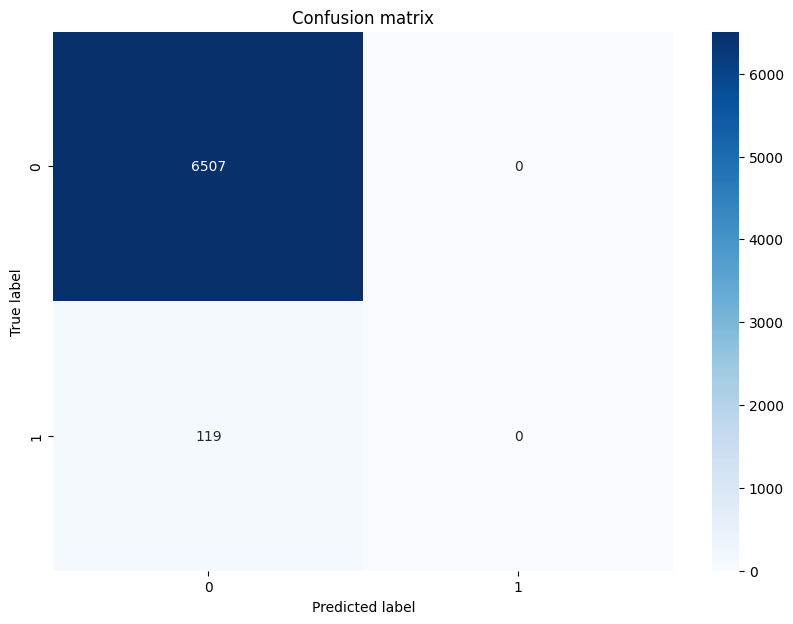

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns

# 1. Evaluate the model on the validation/test dataset
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# 2. Plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

# 3. Generate a classification report and confusion matrix
# Get the true labels and predictions
val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Classification report
report = classification_report(Y_true, Y_pred_classes, target_names=val_generator.class_indices.keys())
print("Classification Report:\n", report)


# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Get the true labels and predictions
val_generator.reset()
Y_true = val_generator.classes
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=list(val_generator.class_indices.keys()))

In [83]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('dataset/ISIC2020/train/ISIC_2020_Training_GroundTruth_v2.csv')

# Iterate through each column and count the occurrences of 0 and 1
for col in df.columns:
    if df[col].dtype == 'int64':  # Assuming the columns of interest are integer type
        counts = df[col].value_counts()
        count_0 = counts.get(0, 0)
        count_1 = counts.get(1, 0)
        print(f"Column '{col}':")
        print(f"Number of '0's: {count_0}")
        print(f"Number of '1's: {count_1}")
        print("")

# Alternatively, if you want to count for a specific column:
# Replace 'your_column_name' with the actual column name from your CSV file
# counts = df['your_column_name'].value_counts()
# count_0 = counts.get(0, 0)
# count_1 = counts.get(1, 0)
# print(f"Number of '0's: {count_0}")
# print(f"Number of '1's: {count_1}")

Column 'target':
Number of '0's: 32542
Number of '1's: 584

